# Estimating the Fundamental Matrix

In [ ]:
import numpy as np
import cv2 as cv
import scipy.io
import sys
from matplotlib import pyplot as plt

#Auxiliary Functions

In [ ]:
# Return the skew matrix formed from a 3x1 vector
def skew(vector):
    return np.array([[0, -vector[2], vector[1]],
                     [vector[2], 0, -vector[0]],
                     [-vector[1], vector[0], 0]])


# Estimate Fundamental Matrix
def estimate_fundamental (ptsl, ptsr):

    npoints = ptsl.shape[1] #number of columns

    if ptsr.shape[1] != npoints:
        raise ValueError("Number of points don't match.")

    # Fundamental Matrix Estimation
    # A_nx9.Fs_9x1 = 0

    A = np.zeros((npoints, 9))

    if npoints < 8:
        print('Too few mesurements')
        sys.exit(0)

    # Stack the equation for each pair of matchings
    for i in range (npoints):

        # A[i] = [ptsl[0,i]*ptsr[0,i], ptsl[0,i]*ptsr[1,i], ptsl[0,i]*ptsr[2,i],
        #         ptsl[1,i]*ptsr[0,i], ptsl[1,i]*ptsr[1,i], ptsl[1,i]*ptsr[2,i],
        #         ptsl[2,i]*ptsr[0,i], ptsl[2,i]*ptsr[1,i], ptsl[2,i]*ptsr[2,i] ]

        A[i,:] = np.kron(ptsl[:,i],ptsr[:,i])

    # Check the matrix rank
    r = np.linalg.matrix_rank(A)

    if r < 8:
        print('Measurement matrix rank defficient')
        sys.exit(0)


    # Compute the SVD of matrix A
    U,S,V = np.linalg.svd(A, full_matrices=True)
    # Pick the eigenvector corresponding to the smallest eigenvalue
    # Define the first estimation for the Fundamental matrix
    F1 = V[-1].reshape(3,3).T

    # Compute the SVD of the Fundamental Matrix
    U,S,V = np.linalg.svd(F1,full_matrices=True)
    # Substitute the diagonal matrix to project the first estimation into the
    # Fundamental Matrix Space/Domain
    s1 = S[0]
    s2 = S[1]
    S = np.diag([s1,s2,0])
    # Compute the new Fundamental Matrix belonging to the right domain
    F = U.dot(S).dot(V)
    # or
    #F = np.dot(U,np.dot(S,V))

    return F/F[2,2]


def estimate_normalized_fundamental (ptsl, ptsr):

    ptsl_n, Tl = normalize(ptsl)
    ptsr_n, Tr = normalize(ptsr)
    # Estimate essential matrix
    F = estimate_fundamental (ptsl_n, ptsr_n)
    # reverse normalization
    F = np.dot(Tr.T,np.dot(F,Tl))

    return F/F[2,2]

# Normalize the points
def normalize(pts):

    # to be sure that the last line is all of ones - homogeneous coordinates
    pts = pts / pts[2]

    npoints = pts.shape[1] # number of columns
    # Calculate the Centroid
    #centx = np.sum (pts[0,:])/npoints
    #centy = np.sum (pts[1,:])/npoints
    centroid = np.mean(pts[:2],axis=1)
    # Calculation of the  mean distance in relation to the centroid
    dist_med = sum(np.sqrt((pts[0,:] - centroid[0])**2 + (pts[1,:] - centroid[1])**2))/npoints
    # Scale to make the mean distance equal to  sqrt(2)
    esc = np.sqrt(2)/dist_med
    esc = np.sqrt(2)/np.std(pts[:2])
    # Normalization matrix
    T = np.array([[esc, 0, -esc*centroid[0]],[0, esc, -esc*centroid[1]],[ 0, 0, 1]])

    #Normalized points
    pts_norm = np.dot(T,pts)

    return pts_norm,T



def compute_epipole(F):
    """ Computes the left epipole e1 (right null space) from a
	  fundamental matrix F.
	  (Use with F.T for right epipole e2 (left null space.) """
    # return null space of F (Fx=0)
    U,S,V = np.linalg.svd(F)
    e = V[-1]
    return e/e[2]



def plot_epipolar_line(im,F,x,epipole=None,show_epipole=True):
	""" Plot the epipole and epipolar line F*x=0
	in an image. F is the fundamental matrix
	and x a point in the other image."""

	m,n = im.shape[:2]
	line = np.dot(F,x)

	# epipolar line parameter and values
	t = np.linspace(0,n,100)
	lt = np.array([(line[2]+line[0]*tt)/(-line[1]) for tt in t])

	# take only line points inside the image
	ndx = (lt>=0) & (lt<m)
	plt.plot(t[ndx],lt[ndx],linewidth=1)
	if show_epipole:
		if epipole is None:
			epipole = compute_epipole(F)
		plt.plot(epipole[0]/epipole[2],epipole[1]/epipole[2],'r*')




#Example Cases

In [ ]:
def case_one():
    # Read images
    img1 = cv.imread('boxes1.bmp') #left image
    img2 = cv.imread('boxes8.bmp') #right image

    img_left = cv.cvtColor(img1,cv.COLOR_BGR2RGB)
    img_right = cv.cvtColor(img2,cv.COLOR_BGR2RGB)


    # Read points that were collected manually
    data = scipy.io.loadmat('boxpoints.mat')

    xim = data['xim']

    pts_left = xim[:,:,0]
    pts_right = xim[:,:,1]

    return img_left,img_right,pts_left,pts_right

def case_two():
    # Read images
    img1 = cv.imread('001.jpg') #left image
    img2 = cv.imread('002.jpg') #right image

    img_left = cv.cvtColor(img1,cv.COLOR_BGR2RGB)
    img_right = cv.cvtColor(img2,cv.COLOR_BGR2RGB)


    # Read points from file
    points2D = [np.loadtxt('00'+str(i+1)+'.corners').T for i in range(2)]
    # load correspondences
    corr = np.genfromtxt('nview-corners',dtype='int',missing_values='*')

    # index for points in first two views
    ndx = (corr[:,0]>=0) & (corr[:,1]>=0)
    # get coordinates and make homogeneous
    pts_left = points2D[0][:,corr[ndx,0]]
    pts_left = np.vstack( (pts_left,np.ones(pts_left.shape[1])) )
    pts_right = points2D[1][:,corr[ndx,1]]
    pts_right = np.vstack( (pts_right,np.ones(pts_right.shape[1])) )

    return img_left,img_right,pts_left,pts_right

def case_three():
    #Read images
    imgl = cv.imread('colorLeft.png')  #queryimage # left image
    imgr = cv.imread('colorRight.png') #trainimage # right image

    # find the keypoints and descriptors with SIFT
    sift = cv.SIFT_create()
    kp1, des1 = sift.detectAndCompute(imgl,None)
    kp2, des2 = sift.detectAndCompute(imgr,None)

    # Solve matching between detected points in both images
    # FLANN parameters
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)
    flann = cv.FlannBasedMatcher(index_params,search_params)
    matches = flann.knnMatch(des1,des2,k=2)
    good = []
    ptsl = []
    ptsr = []

    # Select good matches
    # ratio test as per Lowe's paper
    for i,(m,n) in enumerate(matches):

        if m.distance < 0.7*n.distance:
            good.append(m)
            ptsr.append(kp2[m.trainIdx].pt)
            ptsl.append(kp1[m.queryIdx].pt)


    ptsl = np.int32(ptsl).T
    ptsr = np.int32(ptsr).T
    ptsl = np.vstack( (ptsl,np.ones(ptsl.shape[1])) )
    ptsr = np.vstack( (ptsr,np.ones(ptsr.shape[1])) )

    return imgl,imgr,ptsl,ptsr


#Main


Fundamental Matrix obtained by our method without Ransac: 
 F = 
 [[ 3.73375030e-06 -4.45906668e-06 -2.38940067e-05]
 [ 1.04497659e-05  2.31610782e-06 -3.92133805e-03]
 [-3.66056130e-03  6.22958897e-04  1.00000000e+00]]

Fundamental Matrix obtained by our normalized method without Ransac: 
 F = 
 [[-1.86798409e-06 -6.85782834e-05  3.72802744e-02]
 [ 7.90193711e-05 -2.06219400e-05 -1.02843696e-01]
 [-3.81613051e-02  1.06409778e-01  1.00000000e+00]]

Fundamental Matrix obtained with OpenCV function: 
 F = 
 [[-1.63246923e-06 -5.67359074e-05  3.58403554e-02]
 [ 1.00750687e-04 -3.60585279e-05 -5.60202386e-01]
 [-4.58435419e-02  5.60201742e-01  1.00000000e+00]]


(-0.5, 672.025, 479.5, -0.5)

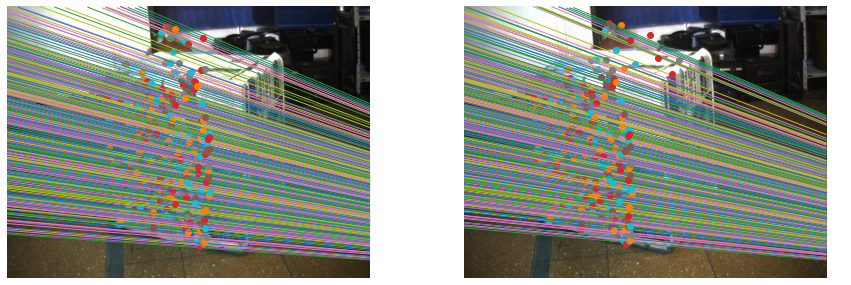

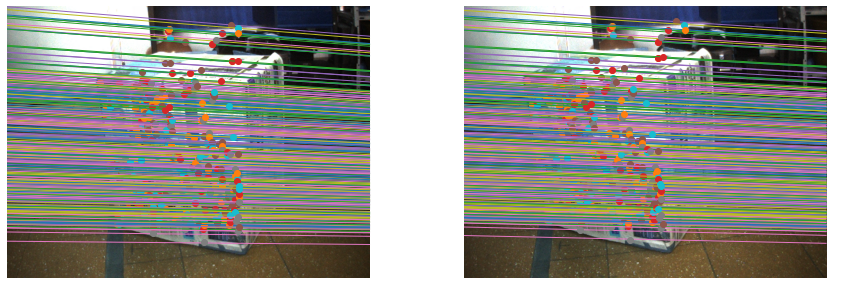

In [ ]:
CASE = 3

if CASE == 1:
    img_left,img_right,pts_left,pts_right = case_one()

    n_epilines = pts_left.shape[1]

if CASE == 2:
    img_left,img_right,pts_left,pts_right = case_two()
    n_epilines = 40

if CASE == 3:
    img_left,img_right,pts_left,pts_right = case_three()
    n_epilines = 400



# Estimate the Fundamental Matrix with out Ransac
F1 = estimate_fundamental (pts_left, pts_right)
F2 = estimate_normalized_fundamental (pts_left, pts_right)
ptsl = pts_left
ptsr = pts_right

print('\nFundamental Matrix obtained by our method without Ransac: \n F = \n',F1)
print('\nFundamental Matrix obtained by our normalized method without Ransac: \n F = \n',F2)

# compute the epipole in the left image (first image)
e1 = compute_epipole(F1)

# compute the epipole in the right image (second image)
e2 = compute_epipole(F1.T)


# plotting
plt.figure(figsize=(15,8))
plt.subplot(121)
plt.imshow(img_left)

# plot each line individually, this gives nice colors
for i in range(n_epilines):
    plot_epipolar_line(img_left,F2.T,ptsr[:,i],e1,False)
    plt.plot(ptsl[0,i],ptsl[1,i],'o')
plt.axis('off')

plt.subplot(122)
plt.imshow(img_right)
# plot each point individually, this gives same colors as the lines
for i in range(n_epilines):
    plot_epipolar_line(img_right,F2,ptsl[:,i],e2,False)
    plt.plot(ptsr[0,i],ptsr[1,i],'o')
plt.axis('off')




# Using OpenCV

pts1 = pts_left[0:2,:].T
pts2 = pts_right[0:2,:].T


#F2, mask = cv.findFundamentalMat(pts1,pts2,cv.FM_8POINT) #FM_8POINT
F2, mask = cv.findFundamentalMat(pts1,pts2,cv.RANSAC,1,0.9999999)
print('\nFundamental Matrix obtained with OpenCV function: \n F = \n',F2)

# We select only inlier points
pts1 = pts1[mask.ravel()==1].T
pts1 = np.vstack((pts1,np.ones(pts1.shape[1])))
pts2 = pts2[mask.ravel()==1].T
pts2 = np.vstack((pts2,np.ones(pts2.shape[1])))

# compute the epipole in the left image (first image)
e1 = compute_epipole(F2)

# compute the epipole in the right image (second image)
e2 = compute_epipole(F2.T)

if pts1.shape[1]< n_epilines:
  n_epilines= pts1.shape[1]


# plotting
plt.figure(figsize=(15,8))
plt.subplot(121)
plt.imshow(img_left)

# plot each line individually, this gives nice colors
for i in range(n_epilines):
    plot_epipolar_line(img_left,F2.T,pts2[:,i],e1,False)
    plt.plot(pts1[0,i],pts1[1,i],'o')
plt.axis('off')

plt.subplot(122)
plt.imshow(img_right)

# plot each point individually, this gives same colors as the lines
for i in range(n_epilines):
    plot_epipolar_line(img_right,F2,pts1[:,i],e2,False)
    plt.plot(pts2[0,i],pts2[1,i],'o')
plt.axis('off')

